<h1>Fine tuning LLAMA 3.2 Vision</h1>
This notebook uses the Watchman dataset data to fine tune the LLAMA 3.2 Vision Instruct model</br>
and deploy the fine tuned version to be served by vLLM.</br>
It uses Unsloth for fine tuning. In order to fit to single 24G VRAM GPU (no free multi-GPU support in Unsloth now)</br>
it loads 4-bit quatized base model weights. After fine-tuning, when merging the LoRA adapters and exporting the</br>
resulted weights are converted to 16bit. At the moment this appears to be the only easily available option.</br>

Notes:
- Will be doing plain LoRA fine tuning, nothing fancy to start with.
- Unsloth looks like the easiest path forward:</br>
https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb
- Apparently, Unsloth will only work on 1 GPU for free... Still worth a try w/ the 4bit quantized model.
- Will try fine tuning for the vision layers only first.
- Installed it using "pip3 install unsloth" (looks like it updated torch version..., everything still works fine).

---

In [ ]:
import os
import sys
import gc
import base64
from pathlib import Path
import pandas as pd
from PIL import Image
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
import numpy as np
from unsloth import FastVisionModel
from unsloth.trainer import UnslothVisionDataCollator
from torch.utils.data import Dataset
import torch
from unsloth import is_bf16_supported
from trl import SFTTrainer, SFTConfig
from openai import OpenAI

In [41]:
# cleanup
model = None
processor = None
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model, processor = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = False, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 42,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

In [ ]:
# load model interfaces we can use for testing
print(f"Working dir: {os.getcwd()}")
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../orchestrator"))
from shared_settings import *
from model_interfaces import *
print(MODELS)

In [ ]:
# create an instance of the model_name interface (used only to get the prompt from the Watchman code)
model_name = "vllm-complex"
MODEL_INTERFACE = MODELS[model_name]()

In [ ]:
# use pandas dataframe created and saved at the beginning 
pickle_file = "../.data/data-yyyy-mm-dd_hh-mm-ss.pkl"
df = pd.read_pickle(pickle_file)
df.describe()

In [9]:
# Balance the number of samples
def balance_dataset(df, target_column='res'):
    # Separate the classes
    df_yes = df[df[target_column] == 'Yes']
    df_no = df[df[target_column] == 'No']
    
    # Determine which class has fewer samples
    min_samples = min(len(df_yes), len(df_no))
    
    # Resample the larger class to match the size of the smaller class
    if len(df_yes) > len(df_no):
        df_yes = resample(df_yes, replace=False, n_samples=min_samples, random_state=42)
    else:
        df_no = resample(df_no, replace=False, n_samples=min_samples, random_state=42)
    
    # Combine the balanced datasets
    return pd.concat([df_yes, df_no])

In [10]:
# Create training and test sets from the data we have available
df_train, df_test = train_test_split(balance_dataset(df), test_size=0.25)

In [ ]:
df_train.describe()

In [ ]:
df_test.describe()

In [13]:
# Dataset class for the Watchman data
class WatchmanDataset(Dataset):
    def __init__(self, df, WATCHMAN_MODEL_INTERFACE):
        self.df = df
        self.MI = WATCHMAN_MODEL_INTERFACE

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_data = row['img']
        c_desc = row['c_desc']
        o_desc = row['o_desc']
        res = row['res']  # Correct completion without <|end_of_text|>

        # Construct the prompt
        prompt = self.MI.gen_detect_prompt(o_desc, c_desc)

        # Load the image
        image = self.load_image_from_base64(img_data)

        # Prepare completion
        # The untrained model answers with "\n\nYes.<eos>" or "\n\nNo.<eos>", so add the
        # completion for the expected result matching the original as much as possible.
        completion = "\n\n" + res + '.<|end_of_text|>'

        return {
            "prompt": prompt,
            "res": completion,
            "image": image
        }

    def load_image_from_base64(self, base64_string):
        image_data = base64.b64decode(base64_string)
        image = Image.open(BytesIO(image_data)).convert("RGB")
        return image

In [14]:
class WatchmanDataCollator(UnslothVisionDataCollator):
    def __init__(self, model, processor, prompt_end_text = "<|start_header_id|>assistant<|end_header_id|>"):
        super().__init__(model, processor)
        self.text_tokenizer = processor.tokenizer if hasattr(processor, "tokenizer") else processor
        self.prompt_end = self.text_tokenizer(prompt_end_text, add_special_tokens=False)['input_ids']
        self.prompt_end_text = prompt_end_text

    def find_end_of_prompt(self, token_list):
        len_seq = len(self.prompt_end)
        for i in range(len(token_list) - len_seq + 1):
            if token_list[i:i+len_seq] == self.prompt_end:
                return i
        return -1
    
    def __call__(self, examples):
        full_sequences = []
        images = []
        
        for example in examples:    
            prompt = example["prompt"]
            res = example["res"]
            image = example["image"]
            full_sequences.append(prompt + res)
            images.append(image)

        # Tokenize the texts and process the images
        batch = self.processor(
            text    = full_sequences,
            images  = images,
            padding = True,
            add_special_tokens = False,
            return_tensors = "pt",
        )
        batch.pop("token_type_ids", None)

        # Original unsloth collator accepts multiple images,
        # shouldn't matter for the watchman data (single image)
        pixel_values = batch["pixel_values"]
        if type(pixel_values) is list:
            for j, pixel_value_j in enumerate(pixel_values):
                if type(pixel_value_j) is list:
                    for k, pixel_value_k in enumerate(pixel_value_j):
                        pixel_value_j[k] = pixel_value_k.to(self.dtype)
                else:
                    pixel_values[j] = pixel_value_j.to(self.dtype)
            pass
            batch["pixel_values"] = pixel_values
        else:
            batch["pixel_values"] = batch["pixel_values"].to(self.dtype)
        pass

        # Mask prompt and pad tokens before returning the batch
        labels = batch["input_ids"].clone()
        for i, l in enumerate(labels):
            last_match_idx = self.find_end_of_prompt(l.tolist())
            if last_match_idx < 0:
                raise ValueError(f"Invalid prompt,the prompt must end with: {self.prompt_end_text}")
            labels[i, :last_match_idx] = self.ignore_index
        labels[torch.isin(labels, self.padding_token_ids)] = self.ignore_index
        batch["labels"] = labels
        return batch

In [15]:
# Create train and test instances of our custom dataset
if df_test[df_test['res'] == 'No'].shape[0] < 0:
    print("Can't find any No samples in the df_test")
elif df_test[df_test['res'] == 'Yes'].shape[0] < 0:
    print("Can't find any Yes samples in the df_test")
elif df_train[df_train['res'] == 'No'].shape[0] < 0:
    print("Can't find any No samples in the df_train")
elif df_train[df_train['res'] == 'Yes'].shape[0] < 0:
    print("Can't find any Yes samples in the df_train")
else:
    d_train = WatchmanDataset(df_train, MODEL_INTERFACE)
    d_test = WatchmanDataset(df_test, MODEL_INTERFACE)

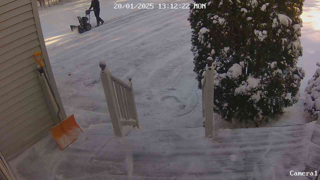

Inference result:  

Yes.
---------------------------


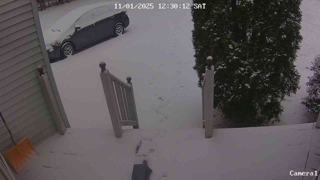

Inference result:  

Yes.
---------------------------


In [16]:
# Enable model for inference
FastVisionModel.for_inference(model)

# Test that we can use the dataset for inference
def find_samples(dataset):
    found_yes = False
    found_no = False
    yes_sample = None
    no_sample = None

    while not (found_yes and found_no):
        sample = dataset[torch.randint(0, len(dataset), (1,)).item()]
        if 'yes' in sample['res'].lower() and not found_yes:
            yes_sample = sample
            found_yes = True
        elif 'no' in sample['res'].lower() and not found_no:
            no_sample = sample
            found_no = True

    return yes_sample, no_sample

# Process the samples
yes_sample, no_sample = find_samples(d_train)

for sample in [yes_sample, no_sample]:
    inputs = processor(sample['image'], sample['prompt'], add_special_tokens=False, return_tensors="pt").to(model.device)
    output = model.generate(
        **inputs,
        use_cache=True,
        max_new_tokens=200,
        temperature=None,
        min_p=None,
        do_sample=False
    )
    # Decode output
    rsp_prefix = processor.decode(inputs.input_ids[0], skip_special_tokens=True)
    response = processor.decode(output[0], skip_special_tokens=True)
    img = sample['image']
    w, h = img.size
    display(img.resize((int(w / 4), int(h / 4))))
    print("Inference result: ", response[len(rsp_prefix):])
    print("---------------------------")

In [17]:
# Run inference on all samples in the dataset and build the truth matrix
def process_dataset(dataset, model, processor):
    truth_matrix = []
    d_len = len(dataset)
    count = 0

    for sample in dataset:
        inputs = processor(
            sample['image'], 
            sample['prompt'], 
            add_special_tokens=False, 
            return_tensors="pt"
        ).to(model.device)
        
        output = model.generate(
            **inputs,
            use_cache=True,
            max_new_tokens=200,
            temperature=None,
            min_p=None,
            do_sample=False
        )
        
        # Decode output
        rsp_prefix = processor.decode(inputs.input_ids[0], skip_special_tokens=True)
        response = processor.decode(output[0], skip_special_tokens=True)
        
        # Determine if the response matches 'yes' or 'no'
        true_answer = sample['res'].lower()
        answer = response[len(rsp_prefix):].lower()
        truth = ("yes" in answer) ^ ("no" in true_answer)
        
        # Append result to truth matrix
        truth_matrix.append({
            'sample': sample,
            'truth': truth,
            'response': answer
        })
        count += 1
        print(f"\rProcessing {count}/{d_len}", end="")        

    print(" done")
    return truth_matrix

# Visualize the truth matrix from process_dataset()
def create_confusion_matrix(truth_matrix):
    # Count all categories
    FN = sum(1 for item in truth_matrix if 'yes' in item['sample']['res'].lower() and not item['truth'])
    TN = sum(1 for item in truth_matrix if 'no' in item['sample']['res'].lower() and item['truth'])
    TP = sum(1 for item in truth_matrix if 'yes' in item['sample']['res'].lower() and item['truth'])
    FP = sum(1 for item in truth_matrix if 'no' in item['sample']['res'].lower() and not item['truth'])

    # Construct the 2x2 matrix
    cm = np.array([
        [FN, TN],
        [TP, FP],
    ])

    # Plot confusion matrix
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')

    # Custom labels for Yes/No
    classes = ['Yes', 'No']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    classes.reverse()
    plt.yticks(tick_marks, classes)

    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2. if cm.max() else 1  # Avoid division by zero if all counts are 0
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
            # Add labels for clarity
            if i == 0 and j == 0:
                plt.text(j, i + 0.3, 'False Negative', ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
            elif i == 0 and j == 1:
                plt.text(j, i + 0.3, 'True Negative', ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
            elif i == 1 and j == 0:
                plt.text(j, i + 0.3, 'True Positive', ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
            else:
                plt.text(j, i + 0.3, 'False Positive', ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()

In [ ]:
# Enable model for inference and do full stats on inference over the test dataset,
# (i.e. for calculating the confusion matrix to see how it performs before training)
FastVisionModel.for_inference(model)
truth_matrix = process_dataset(d_test, model, processor)

Processing 85/85 done


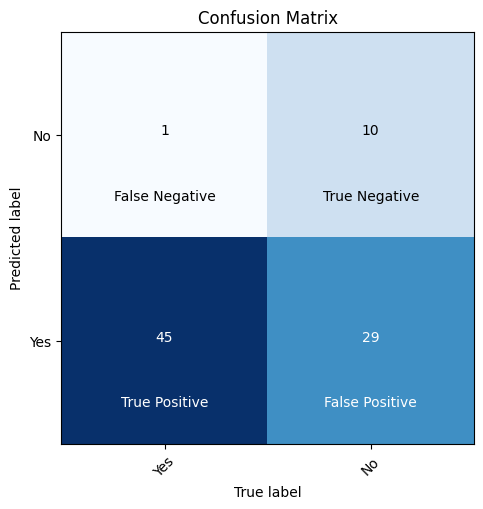

In [19]:
create_confusion_matrix(truth_matrix)

In [11]:
# Create folder for training data
train_data_dir = './trained'
os.makedirs(train_data_dir, exist_ok = True)

In [43]:
# cleanup (in case need to retry the trainer setup)
trainer = None
gc.collect()
torch.cuda.empty_cache()

In [44]:
# Set up the model trainer
trainer = SFTTrainer(
    model = model,
    tokenizer = processor,
    data_collator = WatchmanDataCollator(model, processor),
    train_dataset = d_train,
    args = SFTConfig(
        per_device_train_batch_size = 10,
        gradient_accumulation_steps = 1,
        warmup_steps = 0,
        # max_steps = 10, # Use to try it out (still quite slow)
        num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 42,
        output_dir = f"{train_data_dir}/outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [45]:
# Enable for training and do a train run saving the snapshot after each epoch
epoches_to_train = 10 # 5 should be enough
FastVisionModel.for_training(model)
trainer_stats = []
for count in range(1, epoches_to_train + 1):
    stats = trainer.train()
    trainer_stats.append(stats)
    print(f"Saving LoRA adapters epoch {count}...")
    model.save_pretrained(f"{train_data_dir}/watchman_model{count}")
    processor.save_pretrained(f"{train_data_dir}/watchman_model{count}")

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 255 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 10 | Gradient Accumulation steps = 1
\        /    Total batch size = 10 | Total steps = 26
 "-____-"     Number of trainable parameters = 14,745,600
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,3.520900
2,3.456600
3,3.441800
4,3.307400
5,3.253700
6,3.048100
7,3.008700
8,2.785400
9,2.574300
10,2.466400


Unsloth: Will smartly offload gradients to save VRAM!
Saving LoRA adapters epoch 1...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 255 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 10 | Gradient Accumulation steps = 1
\        /    Total batch size = 10 | Total steps = 26
 "-____-"     Number of trainable parameters = 14,745,600
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,1.374200
2,1.192000
3,1.069700
4,0.991200
5,0.872400
6,0.719400
7,0.603800
8,0.463500
9,0.394300
10,0.247500


Saving LoRA adapters epoch 2...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 255 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 10 | Gradient Accumulation steps = 1
\        /    Total batch size = 10 | Total steps = 26
 "-____-"     Number of trainable parameters = 14,745,600
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,0.015900
2,0.006700
3,0.003100
4,0.002100
5,0.001800
6,0.001100
7,0.001700
8,0.000900
9,0.004000
10,0.040500


Saving LoRA adapters epoch 3...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 255 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 10 | Gradient Accumulation steps = 1
\        /    Total batch size = 10 | Total steps = 26
 "-____-"     Number of trainable parameters = 14,745,600
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,0.000300
2,0.001300
3,0.000300
4,0.001800
5,0.000400
6,-0.000200
7,0.000600
8,0.002000
9,0.001400
10,0.000800


Saving LoRA adapters epoch 4...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 255 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 10 | Gradient Accumulation steps = 1
\        /    Total batch size = 10 | Total steps = 26
 "-____-"     Number of trainable parameters = 14,745,600
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,0.000500
2,0.001200
3,0.000800
4,0.001700
5,0.000900
6,0.001200
7,0.000400
8,0.001000
9,0.000900
10,0.001300


Saving LoRA adapters epoch 5...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 255 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 10 | Gradient Accumulation steps = 1
\        /    Total batch size = 10 | Total steps = 26
 "-____-"     Number of trainable parameters = 14,745,600
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,0.001000
2,0.000700
3,0.001000
4,0.001400
5,0.001100
6,0.001000
7,0.000300
8,0.001000
9,0.000700
10,0.000600


Saving LoRA adapters epoch 6...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 255 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 10 | Gradient Accumulation steps = 1
\        /    Total batch size = 10 | Total steps = 26
 "-____-"     Number of trainable parameters = 14,745,600
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,0.000500
2,0.001300
3,0.000300
4,0.001000
5,0.000400
6,-0.000000
7,0.000200
8,0.001100
9,0.000200
10,0.000500


Saving LoRA adapters epoch 7...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 255 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 10 | Gradient Accumulation steps = 1
\        /    Total batch size = 10 | Total steps = 26
 "-____-"     Number of trainable parameters = 14,745,600
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,0.002100
2,0.000800
3,0.000600
4,0.001100
5,0.000300
6,0.001300
7,0.000700
8,0.001100
9,0.001600
10,0.000900


Saving LoRA adapters epoch 8...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 255 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 10 | Gradient Accumulation steps = 1
\        /    Total batch size = 10 | Total steps = 26
 "-____-"     Number of trainable parameters = 14,745,600
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,0.001500
2,0.000700
3,0.001300
4,0.001100
5,-0.000500
6,0.000500
7,0.000200
8,0.001300
9,0.002000
10,0.001300


Saving LoRA adapters epoch 9...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 255 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 10 | Gradient Accumulation steps = 1
\        /    Total batch size = 10 | Total steps = 26
 "-____-"     Number of trainable parameters = 14,745,600
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,0.001600
2,0.000900
3,0.001400
4,0.001100
5,0.001000
6,0.001100
7,0.001300
8,0.001200
9,0.001100
10,0.000500


Saving LoRA adapters epoch 10...


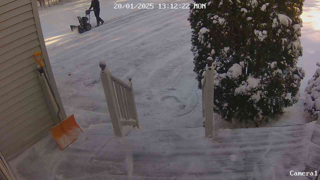

Inference result:  

Yes.
---------------------------


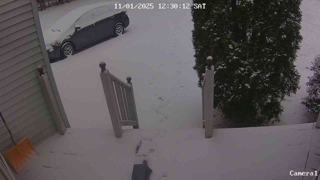

Inference result:  

No.
---------------------------


In [46]:
# Enable model for inference and try how we are doing now with our two test samples.
FastVisionModel.for_inference(model)

for sample in [yes_sample, no_sample]:
    inputs = processor(sample['image'], sample['prompt'], add_special_tokens=False, return_tensors="pt").to(model.device)
    output = model.generate(
        **inputs,
        use_cache=True,
        max_new_tokens=200,
        temperature=None,
        min_p=None,
        do_sample=False
    )
    # Decode output
    rsp_prefix = processor.decode(inputs.input_ids[0], skip_special_tokens=True)
    response = processor.decode(output[0], skip_special_tokens=True)
    img = sample['image']
    w, h = img.size
    display(img.resize((int(w / 4), int(h / 4))))
    print("Inference result: ", response[len(rsp_prefix):])
    print("---------------------------")

In [66]:
def eval_saved_model(saved_model_num):
    dir = f"{train_data_dir}/watchman_model{saved_model_num}"
    model, processor = FastVisionModel.from_pretrained(
        model_name = dir,
        load_in_4bit = True,
    )
    FastVisionModel.for_inference(model)
    truth_matrix = process_dataset(d_test, model, processor)
    create_confusion_matrix(truth_matrix)


In [59]:
# cleanup (in case need to retry the trainer setup)
trainer = None
model = None
processor = None
gc.collect()
torch.cuda.empty_cache()

Evaluate the fine tuned models to see how they perform after each epoch.</br>
Basing on the results will pick one to merge the LoRA adapters and convert the weights</br>
to a compatible for serving format, then deploy for real use evaluation.</br>

==((====))==  Unsloth 2025.1.8: Fast Mllama vision patching. Transformers: 4.48.1.
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.485 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing 85/85 done


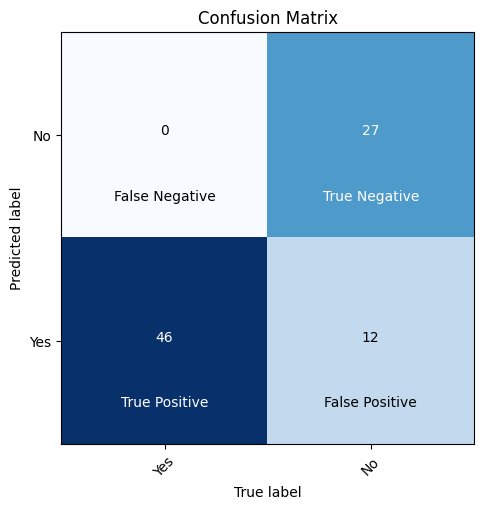

In [67]:
eval_saved_model(1)

==((====))==  Unsloth 2025.1.8: Fast Mllama vision patching. Transformers: 4.48.1.
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.485 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing 85/85 done


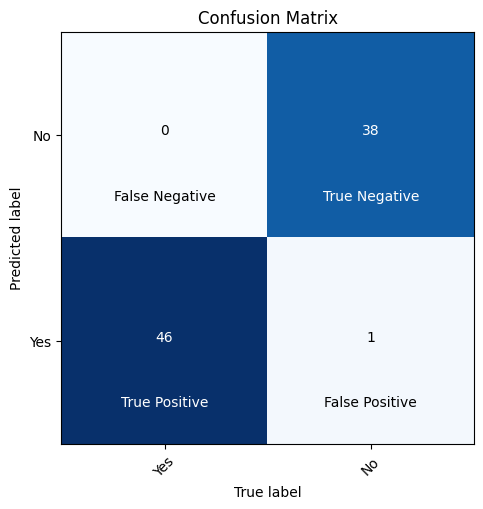

In [68]:
eval_saved_model(2)

==((====))==  Unsloth 2025.1.8: Fast Mllama vision patching. Transformers: 4.48.1.
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.485 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing 85/85 done


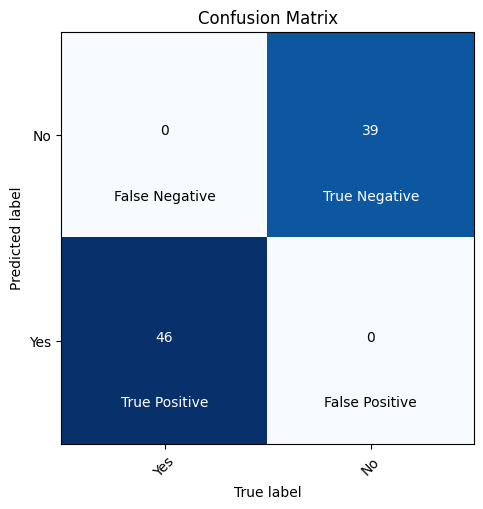

In [69]:
eval_saved_model(3)

==((====))==  Unsloth 2025.1.8: Fast Mllama vision patching. Transformers: 4.48.1.
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.485 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing 85/85 done


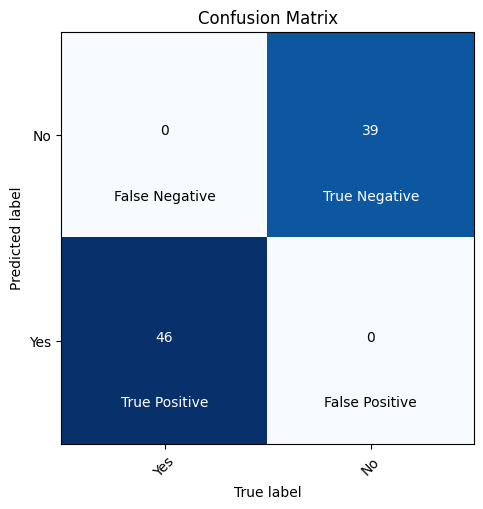

In [70]:
eval_saved_model(4)

==((====))==  Unsloth 2025.1.8: Fast Mllama vision patching. Transformers: 4.48.1.
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.485 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing 85/85 done


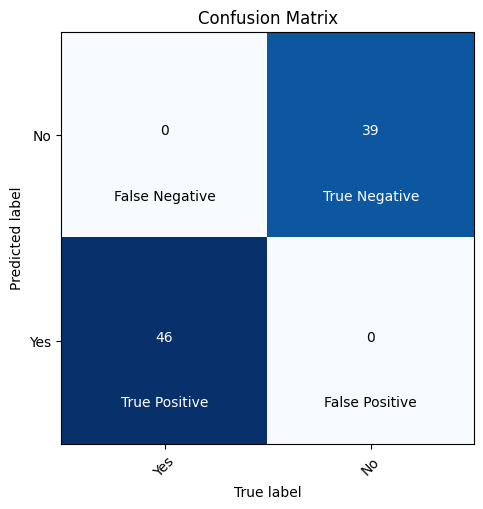

In [71]:
eval_saved_model(5)

==((====))==  Unsloth 2025.1.8: Fast Mllama vision patching. Transformers: 4.48.1.
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.485 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing 85/85 done


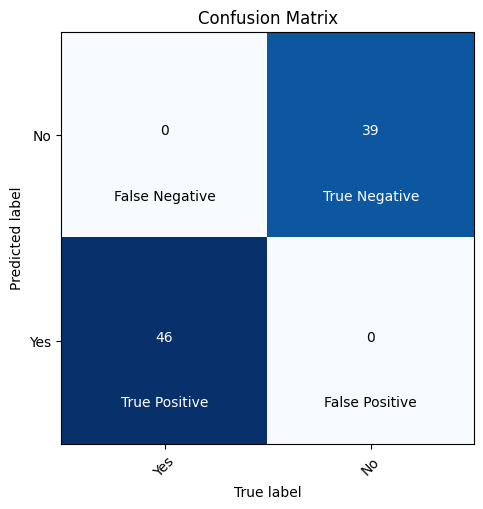

In [72]:
eval_saved_model(6)

==((====))==  Unsloth 2025.1.8: Fast Mllama vision patching. Transformers: 4.48.1.
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.485 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing 85/85 done


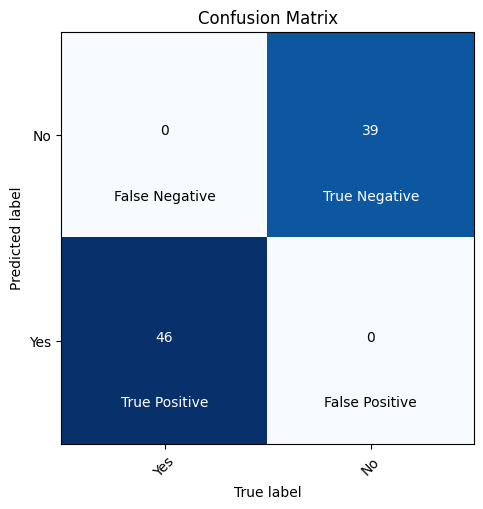

In [73]:
eval_saved_model(7)

==((====))==  Unsloth 2025.1.8: Fast Mllama vision patching. Transformers: 4.48.1.
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.485 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing 85/85 done


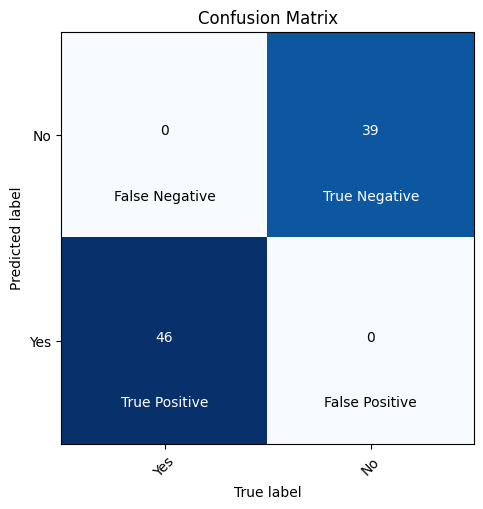

In [74]:
eval_saved_model(8)

==((====))==  Unsloth 2025.1.8: Fast Mllama vision patching. Transformers: 4.48.1.
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.485 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing 85/85 done


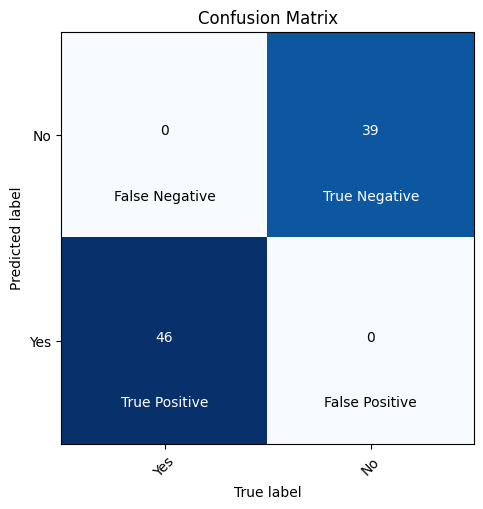

In [75]:
eval_saved_model(9)

==((====))==  Unsloth 2025.1.8: Fast Mllama vision patching. Transformers: 4.48.1.
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.485 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing 85/85 done


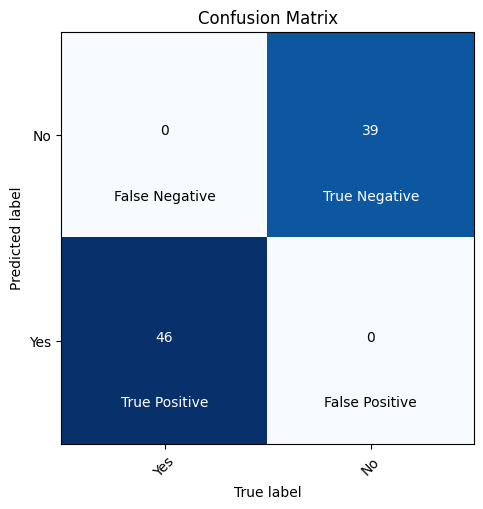

In [76]:
eval_saved_model(10)

After the first 2 epoches the model makes no mistakes.</br>
In order to minimize the chances of overfitting let's use the epoch 3 snapshot.</br>
It's the first one that made it without errors.

==((====))==  Unsloth 2025.1.8: Fast Mllama vision patching. Transformers: 4.48.1.
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.485 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing 255/255 done


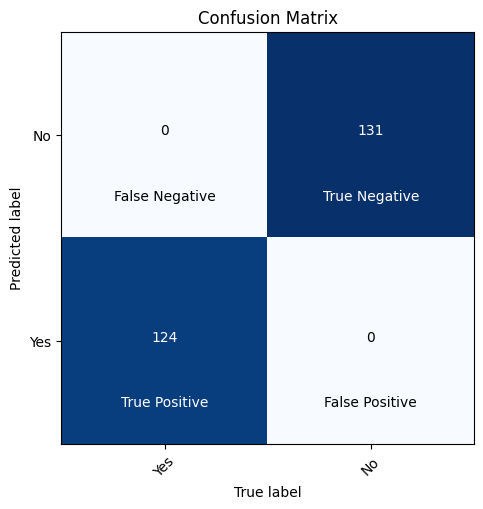

In [77]:
# Load the snapshot 3 and check if it still makes any mistakes on the train data
saved_model_num = 3
dir = f"{train_data_dir}/watchman_model{saved_model_num}"
model, processor = FastVisionModel.from_pretrained(
    model_name = dir,
    load_in_4bit = True,
)
FastVisionModel.for_inference(model)
truth_matrix = process_dataset(d_train, model, processor)
create_confusion_matrix(truth_matrix)

In [ ]:
# Save locally to safetensors 16bit (this should work w/ VLLM).
# Converting the merged model to GGUF or converting just LoRA adapters
# for serving by OLLAMA is not working/implemented for mllama/unsloth yet.
model.save_pretrained_merged(f"{train_data_dir}/watchman_sft_16bit", processor, )

# Savig to GGUF is not supported for the Vision models in Unsloth at the momnet.
# Save to 8bit Q8_0
# model.save_pretrained_gguf("model", processor)
# Save to 16bit GGUF
# model.save_pretrained_gguf("model", processor, quantization_method = "f16")
# Save to q4_k_m GGUF
# model.save_pretrained_gguf(f"{train_data_dir}/watchman_gguf_q4_k_m", processor, quantization_method = "q4_k_m")
# Push to hf:
# model.push_to_hub_gguf("user/model", processor, quantization_method = "f16", token = "")

In [11]:
# As we save merged model in f16 format, there's no qunization anymore.
# It has to be removed from the model's config.json if still there (unsloth bug as of now).
import os
import json
def remove_quantization_from_config_json(config_path):
    # Load JSON file
    with open(config_path, "r") as f:
        config = json.load(f)

    # Remove 'quantization_config' if it exists
    config.pop("quantization_config", None)

    # Save back the modified JSON
    with open(config_path, "w") as f:
        json.dump(config, f, indent=4)

remove_quantization_from_config_json(f"{train_data_dir}/watchman_sft_16bit/config.json")

In [84]:
# Cleanup as we now going to try serving the model with vLLM
trainer = None
model = None
processor = None
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Set up vLLM (outside of this notebook environment). We'll have it serve the fine-tuned model on the system w/ 2 RTX3090 cards.
# In order to bypass the chat templates mess, we will use .jinja file that passes Watchman prompt directly for messages w/ role set to "watchman".
# If using just one card with enough memory, remove the "--tensor-parallel-size 2" option. If out of memory, try reducing "--max_model_len 2048" and/or "--max-num-seqs 16".
# Generate the command to start serving the local fine tuned model:
print(f"vllm serve {os.path.abspath(train_data_dir)}/watchman_sft_16bit --chat-template {os.path.abspath('.')}/watchman_sft_16bit_chat_tpl.jinja --tensor-parallel-size 2 --enforce-eager --gpu-memory-utilization 0.9 --max_model_len 2048 --max-num-seqs 16 --port 5050")

In [ ]:
# Run the above commans and check if we can poke the server.
!curl http://127.0.0.1:5050/version

Now, let's confirm that the model works as expected when seved by vLLM.</br>
This is done in the vllm-fine_tune-test.ipnb notebook.</br>